In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip "/content/drive/MyDrive/NVIDIA_AI_CHALLENGE/Data/Tracked-Vehicle Retrieval by Natural Language Descriptions/AIC22_Track2_NL_Retrieval.zip" 

In [ ]:
# !python extract_vdo_frms.py --data_root './validation/S02'

In [ ]:
%cd /content/drive/MyDrive/NVIDIA_AI_CHALLENGE/Data/Tracked-Vehicle_Retrieval_by_Natural_Language_Descriptions

/content/drive/.shortcut-targets-by-id/1zMRVgIszziKXTHyFVbdCpNkDl69lZ482/NVIDIA_AI_CHALLENGE/Data/Tracked-Vehicle_Retrieval_by_Natural_Language_Descriptions


In [ ]:
!ls

 AIC22_Track2_NL_Retrieval.zip	 README.md	     train
'Dataset License AIC2022.pdf'	 test_queries.json   train_tracks.json
 extract_vdo_frms.py		 test_tracks.json    validation


In [ ]:
import json

with open("train_tracks.json", "r") as f:
    data = json.load(f)

In [ ]:
import random

sample_data = data[list(data.keys())[random.randint(0, len(data.keys()))]]

In [ ]:
# sample_data = data['b06c903c-a25d-45fe-b0d5-294f72e34023']

Populating the interactive namespace from numpy and matplotlib
time to compute a single sample: 52.73881459236145


(-0.5, 1919.5, 1079.5, -0.5)

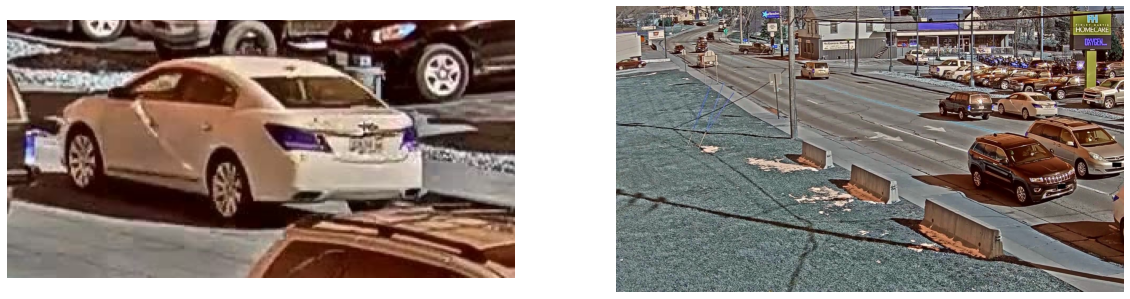

In [ ]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as Img
import cv2
import time

start = time.time()
def get_image_context_bbox(image_path, bbox):
    original_img = cv2.imread(image_path)
    x, y, w, h = bbox
    cropped_image = original_img[y:y+h, x:x+w]
    return original_img, cropped_image

context_img, cropped_image = get_image_context_bbox(sample_data['frames'][0], sample_data['boxes'][0])

end = time.time()
print(f"time to compute a single sample: {end-start}")

fig = plt.figure(figsize=(20, 12))
fig.add_subplot(1, 2, 1)
plt.imshow(cropped_image)
plt.axis('off')

fig.add_subplot(1, 2, 2)
plt.imshow(context_img)
plt.axis('off')

In [ ]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [ ]:
import numpy as np

def get_motion_img(img_path_list, boxes_list):
    w, h, c = cv2.imread(img_path_list[0]).shape
    motion_img = np.zeros((w, h, c), dtype=np.int16)
    line_motion_img = np.zeros((w, h, c), dtype=np.int16)
    
    center_points = []

    first = boxes_list[0][2] * boxes_list[0][3]
    last = boxes_list[-1][2] * boxes_list[-1][3]

    if last < first:
        print("IS REVERSED")
        img_path_list = img_path_list[::-1]
        boxes_list = boxes_list[::-1]


    prev_box = []
    for idx, img_path in enumerate(img_path_list):
        img = cv2.imread(img_path)

        if len(prev_box) == 0:
            x, y, w, h = boxes_list[idx]
            prev_box = [x, y, x+w, y+h]
        else:
            x, y, w, h = boxes_list[idx]
            curr_box = [x, y, x+w, y+h]
            if bb_intersection_over_union(prev_box, curr_box) > 0.5:
                continue
            else:
                prev_box = curr_box

        x, y, w, h = boxes_list[idx]


        motion_img[y:y+h, x:x+w, :] = img[y:y+h, x:x+w, :]
        center_points.append((int(x+ w/2),int(y + h/2)))
    center_points = np.array(center_points)
    
    cv2.drawContours(line_motion_img, [center_points], 0, (255,255,255), 160)
    return line_motion_img, motion_img

IS REVERSED
Time to compute a single sample:  26.52537226676941


(-0.5, 1919.5, 1079.5, -0.5)

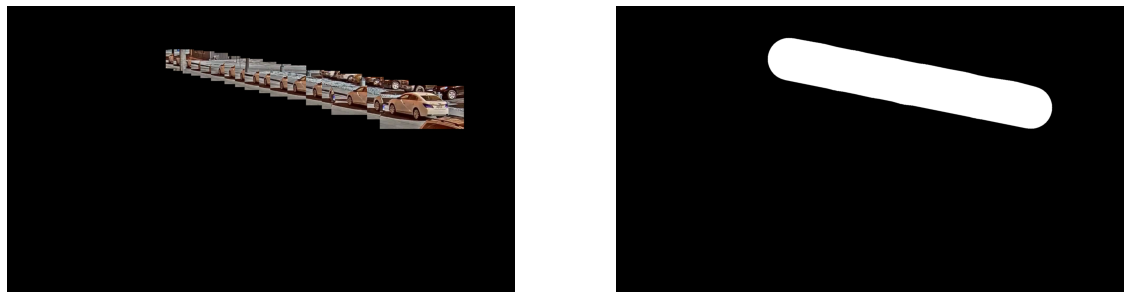

In [ ]:
import time

start = time.time()
line_motion_img, motion_img = get_motion_img(sample_data['frames'], sample_data['boxes'])
end = time.time()

print("Time to compute a single sample: ", end - start)

fig = plt.figure(figsize=(20, 12))
fig.add_subplot(1, 2, 1)
plt.imshow(motion_img)
plt.axis('off')

fig.add_subplot(1, 2, 2)
plt.imshow(line_motion_img)
plt.axis('off')

In [ ]:
for data_key in data.keys():
    data_sample = data[data_key]
    area = []
    for box in data_sample['boxes']:
        x,y,w,h = box
        area.append((w,h))

In [ ]:
widths = [area[x][0] for x in range(len(area))]
heights = [area[x][1] for x in range(len(area))]

In [ ]:
np.max(widths), np.min(widths), np.mean(widths)

(442, 121, 217.14093959731542)

In [ ]:
np.max(heights), np.min(heights), np.mean(heights)

(389, 103, 194.6510067114094)

In [ ]:
!pip install validators matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cpu for inference


In [ ]:
import timm

efficientnet = timm.create_model('efficientnet_b4', pretrained=True)
# utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

efficientnet.eval().to(device)

EfficientNet(
  (conv_stem): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
    

In [ ]:
efficientnet.classifier = nn.Identity()

In [ ]:
data_sample = data['00c5e732-25ee-4a52-be48-29a67e237bb3']

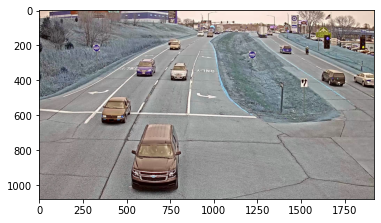

In [ ]:
for frame in data_sample['frames']:
    img = cv2.imread(frame)
    plt.imshow(img)

In [ ]:
challenge_batch = torch.tensor([cv2.resize(cv2.imread(frame), (224, 224)).reshape((3,224,224)) for frame in data_sample['frames']], dtype=torch.float32)

In [ ]:
challenge_batch.shape

torch.Size([59, 3, 224, 224])

In [ ]:
efficientnet

EfficientNet(
  (conv_stem): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
    

In [ ]:
with torch.no_grad():
    output = efficientnet(challenge_batch)

In [ ]:
output.shape

torch.Size([59, 1792])

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self, image_encoder=efficientnet, context_encoder=efficientnet, 
                 motion_encoder=efficientnet, motion_line_encoder=efficientnet):
        super().__init__()

        self.image_encoder = image_encoder
        self.context_encoder = context_encoder
        self.motion_encoder = motion_encoder
        self.motion_line_encoder = motion_line_encoder

    def forward(self, input):
        # print(input)
        image_features = self.image_encoder(input['image'])
        context_features = self.context_encoder(input['context'])
        motion_features = self.motion_encoder(input['motion'])
        motion_line_features = self.motion_line_encoder(input['motion_line'])

        return image_features, context_features, motion_features, motion_line_features

In [ ]:
from tqdm import tqdm

class Track2CustomDataset(Dataset):
    def __init__(self, data_tracks, transforms):
        samples = []    
        for key, sample in tqdm(data_tracks.items(), total=len(data_tracks.items())):
            
            frames_paths = sample['frames']
            frames_boxes = sample['boxes']
            samples += [(frames_paths[idx], frames_boxes[idx], frames_paths, frames_boxes) for idx in range(len(frames_paths))]
        self.samples = samples
        self.transforms = transforms
    
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        frame_path, frame_boxes, all_frames, all_boxes = self.samples[index]

        context, image = get_image_context_bbox(frame_path, frame_boxes)
        motion, motion_line = get_motion_img(all_frames, all_boxes)

        sample = {'image': image.astype(np.float32), 'context': context.astype(np.float32), 
                  'motion': motion.astype(np.float32), 'motion_line': motion_line.astype(np.float32)}

        if self.transforms:
            sample['image'] = self.transforms(sample['image'])
            sample['context'] = self.transforms(sample['context'])
            sample['motion'] = self.transforms(sample['motion'])
            sample['motion_line'] = self.transforms(sample['motion_line'])

        return sample

In [ ]:
def get_transforms(img_size, train, size=1):
    if train:
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomResizedCrop(img_size * size, scale=(0.8, 1)),
            transforms.RandomApply([transforms.RandomRotation(10)], p=0.5),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
    else:
        return transforms.Compose([
            transforms.Resize(img_size * size, img_size),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

In [ ]:
dataset = Track2CustomDataset(data, transforms=get_transforms(224, train=True))

100%|██████████| 2155/2155 [00:00<00:00, 6965.30it/s]


In [ ]:
image_encoder = ImageEncoder()

In [ ]:
sample = dataset[0]

In [ ]:
sample['image'].shape, sample['context'].shape, sample['context'].shape, sample['motion_line'].shape, 

(torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224]))

In [ ]:
dataloader = DataLoader(dataset, batch_size=1,
                        shuffle=False, num_workers=0)

In [ ]:
dataloader

In [ ]:
for i_batch, sample_batched in enumerate(dataloader):
    with torch.no_grad():
        image_embeddings, context_embeddings, motion_embeddings, motion_line_embeddings = image_encoder(sample_batched)
    break

In [ ]:
image_embeddings.shape, context_embeddings.shape, motion_embeddings.shape, motion_line_embeddings.shape

(torch.Size([1, 1792]),
 torch.Size([1, 1792]),
 torch.Size([1, 1792]),
 torch.Size([1, 1792]))